In [24]:
from datetime import datetime
import matplotlib.dates as mdates
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pygeohash as pgh
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sktools import GradientBoostingFeatureGenerator
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline



In [25]:
df = pd.read_csv(r'D:\UCL\Term3\tbx-flaring-shihao\data\final_data\final_df.csv')

In [26]:
df1 = df.drop(columns=['Unnamed: 0.1','api','state','basin','style','wellpads_id','Unnamed: 0.2','id_','confidence','source_id','spatial_group','temporal_group','X','Y','best_estimate_diff'])
df1.columns

Index(['Unnamed: 0', 'subbasin', 'county', 'tst_permit_date',
       'tst_permit_published_date', 'tst_spud_date', 'tst_completion_date',
       'tst_fracfocus_jobstart_date', 'tst_fracfocus_jobend_date', 'lat',
       'long', 'wells', 'area_m2', 'tst_first_detection_date', 'company_type',
       'wellpad_vintage_year', 'flare_t_start', 'flare_t_end', 'comp_diff',
       'spud_diff', 'permit_diff', 'detection_diff', 'power', 'rad', 'aq_date',
       't_diff', 'days_diffs', 'pad_status'],
      dtype='object')

In [27]:
df1['aq_date'] = pd.to_datetime(df1['aq_date'], format='%Y%m%d %H:%M')
df1['flare_t_start'] = pd.to_datetime(df1['flare_t_start'], format='%Y%m%d %H:%M')
df1['flare_t_end'] = pd.to_datetime(df1['flare_t_end'], format='%Y%m%d %H:%M')
df1['flare_t_start_tillnow'] = pd.to_datetime("today").date() - df1['flare_t_start'].dt.date
df1['flare_t_end_tillnow'] = pd.to_datetime("today").date() - df1['flare_t_end'].dt.date

df1['flaring_event_tillnow'] = pd.to_datetime("today").date() - df1['aq_date'].dt.date

df1['flaring_event_till3month_fromnow'] = df1['flaring_event_tillnow'].apply(lambda x: 1 if x >np.timedelta64(180, 'D') else 0)# 10,100...  slightly lower acc, but 180 still above 80%+

df1 = df1.drop(columns=['tst_permit_date','tst_permit_published_date','tst_spud_date','tst_completion_date','tst_fracfocus_jobstart_date','tst_fracfocus_jobend_date','tst_first_detection_date','t_diff','flare_t_start','flare_t_end','aq_date'])

df1['flare_t_start_tillnow'] = df1['flare_t_start_tillnow']/np.timedelta64(1, 'D')
df1['flare_t_end_tillnow']= df1['flare_t_end_tillnow']/np.timedelta64(1, 'D')
df1['flaring_event_tillnow'] = df1['flaring_event_tillnow']/np.timedelta64(1, 'D')

In [28]:
df1

,Unnamed: 0,subbasin,county,lat,long,wells,area_m2,company_type,wellpad_vintage_year,comp_diff,...,permit_diff,detection_diff,power,rad,days_diffs,pad_status,flare_t_start_tillnow,flare_t_end_tillnow,flaring_event_tillnow,flaring_event_till3month_fromnow
0,90222,Delaware,Loving,31.9281,-103.6350,3,22543.56642,Private,2022,62.0,...,103.0,140.0,0.240971,0.447881,123.0,4,2857.0,2809.0,2857.0,1
1,90222,Delaware,Loving,31.9281,-103.6350,3,22543.56642,Private,2022,62.0,...,103.0,140.0,0.731796,0.384363,1.0,4,2857.0,2809.0,2855.0,1
2,90222,Delaware,Loving,31.9281,-103.6350,3,22543.56642,Private,2022,62.0,...,103.0,140.0,0.998371,0.413679,2.0,4,2857.0,2809.0,2853.0,1
3,90222,Delaware,Loving,31.9281,-103.6350,3,22543.56642,Private,2022,62.0,...,103.0,140.0,0.822643,0.408657,0.0,4,2857.0,2809.0,2853.0,1
4,90222,Delaware,Loving,31.9281,-103.6350,3,22543.56642,Private,2022,62.0,...,103.0,140.0,0.370339,0.395678,0.0,4,2857.0,2809.0,2852.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2421,89875,Midland,Dawson,32.8602,-101.7362,1,11059.22690,Private,2021,NaN,...,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,0
2422,90172,Delaware,Loving,31.9281,-103.6398,3,21532.55194,Public,2022,NaN,...,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,0
2423,90175,Delaware,Loving,31.9281,-103.6397,3,21532.55194,Public,2022,NaN,...,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,0
2424,90183,Delaware,Loving,31.9281,-103.6398,3,21532.55194,Public,2022,NaN,...,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,0


In [29]:
df_LR = df1.drop(columns=['flaring_event_tillnow','flare_t_start_tillnow','Unnamed: 0','wellpad_vintage_year'])
#df_LR = df1.drop(columns=['flaring_event_tillnow','flare_t_start_tillnow'])

C:\Users\Shihao Zhou\AppData\Local\Temp\ipykernel_9048\2404936151.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_tb, dtype=np.bool)


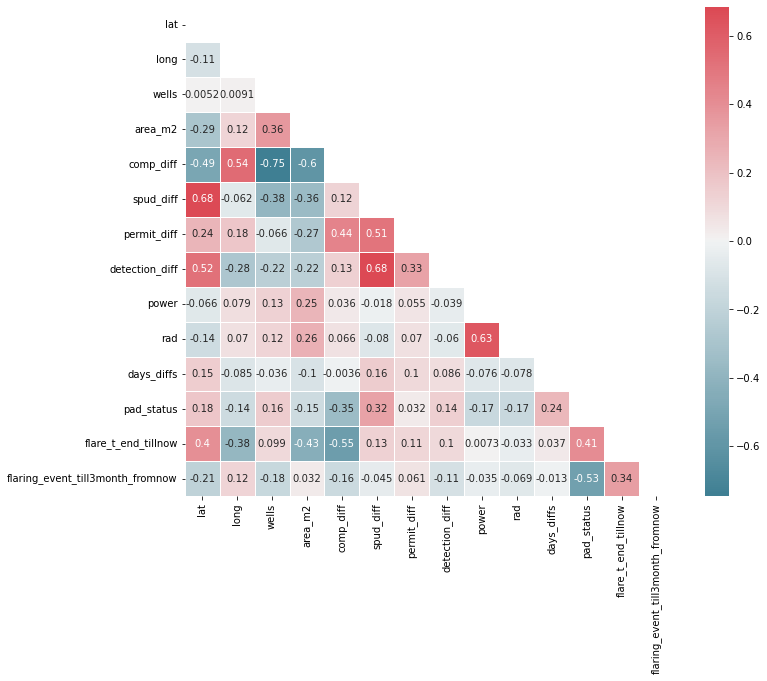

In [30]:
# create correlation table
corr_tb = df_LR.corr()

# create mask
mask = np.zeros_like(corr_tb, dtype=np.bool)
mask[np.triu_indices_from(mask, k=0)] = True

# generate colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# initialise figure
f, ax = plt.subplots(figsize=(11, 9))

# draw heatmap
sns.heatmap(corr_tb, mask=mask, cmap=cmap, center=0, 
            annot=True, square=True, linewidths=.5) 

# show figure
plt.show()

In [31]:
#df_LR['geohash']=df_LR.apply(lambda x: pgh.encode(x.lat, x.long, precision=5), axis=1)


In [32]:
df_LR = pd.get_dummies(df_LR,drop_first = True)

In [33]:
#df_LR = df_LR.drop(columns=['lat','long'])

In [34]:
df_LR.isnull().sum()

lat                                    0
long                                   0
wells                                  0
area_m2                                0
comp_diff                           1640
spud_diff                            850
permit_diff                          850
detection_diff                       904
power                                869
rad                                  869
days_diffs                           869
pad_status                             0
flare_t_end_tillnow                  850
flaring_event_till3month_fromnow       0
subbasin_Midland                       0
county_Borden                          0
county_Chaves                          0
county_Cochran                         0
county_Crane                           0
county_Crockett                        0
county_Crosby                          0
county_Culberson                       0
county_Dawson                          0
county_Dickens                         0
county_Ector    

In [35]:
df_LR = df_LR.fillna(df_LR.mean())

In [36]:
X = df_LR.loc[:, df_LR.columns != 'flaring_event_till3month_fromnow']
y = df_LR.loc[:, df_LR.columns == 'flaring_event_till3month_fromnow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [37]:
gbf = GradientBoostingFeatureGenerator()
lr = LogisticRegression()

pipe = Pipeline([("gb_features", gbf), ("logistic", lr)])

pipe.fit(X_train, y_train)

y_pred_prob = pipe.predict_proba(X_test)


D:\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
D:\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed w

In [38]:
y_pred_prob

array([[9.15126043e-01, 8.48739571e-02],
       [5.52747081e-02, 9.44725292e-01],
       [5.15037061e-01, 4.84962939e-01],
       ...,
       [7.71649146e-01, 2.28350854e-01],
       [8.17128681e-01, 1.82871319e-01],
       [9.90516593e-08, 9.99999901e-01]])

In [39]:
y_pred_new_threshold = (pipe.predict_proba(X_test)[:,1]>=0.6).astype(int)


D:\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
D:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [40]:

score =accuracy_score(y_test,y_pred_new_threshold)
print(f"The accuracy of GBDT & logistic regression on test set: {score:.2%}.")

The accuracy of GBDT & logistic regression on test set: 92.13%.


In [42]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, y_pred_new_threshold)
roc_auc

0.9261195482866044

In [44]:
from sklearn.metrics import f1_score

f1_score(y_test, y_pred_new_threshold)

0.9321851453175457